In [2]:
import pyodbc
import sqlite3
import pandas as pd
import datetime as datetime
import warnings
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [26]:


DB_SOURCE = {
    'servername': r'LAPTOP-PRQNR6SS\SQLEXPRESS',
    'database': 'SDM'
}



source_conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    f"SERVER={DB_SOURCE['servername']};"
    f"DATABASE={DB_SOURCE['database']};"
    "Trusted_Connection=yes;"
)



DB_SOURCE2 = {
    'servername': r'LAPTOP-PRQNR6SS\SQLEXPRESS',
    'database': 'Ster_schema'
}



source_conn2 = pyodbc.connect(
    'DRIVER={SQL Server};'
    f"SERVER={DB_SOURCE2['servername']};"
    f"DATABASE={DB_SOURCE2['database']};"
    "Trusted_Connection=yes;"
)

source_cursor = source_conn.cursor()
source_cursor2 = source_conn2.cursor()


print("Succesvol verbonden met databases!")

Succesvol verbonden met databases!


### Alle tabellen

In [8]:
# Haal een lijst van tabellen op uit de bron-database
sql_query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"


# Gebruik pandas om de query uit te voeren en de tabellen op te halen
tables_df = pd.read_sql(sql_query, source_conn)

# Print de lijst van tabellen
tables_df

,TABLE_NAME
0,Country
1,Date_dim
2,Month_dim
3,Sales_staff
4,Retailer
5,Retailer_contact
6,Product
7,fact_orders
8,fact_returned_item
9,fact_product_forecast


In [27]:
order_query = 'SELECT * FROM order_details'
order_df = pd.read_sql(order_query, source_conn)

returned_items_query = 'SELECT * FROM returned_item'
returned_items_df = pd.read_sql(returned_items_query, source_conn)

returned_reason_query = 'SELECT * FROM return_reason'
returned_reason_df = pd.read_sql(returned_reason_query, source_conn)

product_query = 'SELECT * FROM Product'
product_df = pd.read_sql(product_query, source_conn2)

### ----

In [30]:
return_item_df = pd.merge(returned_items_df, returned_reason_df, how='inner', on = 'RETURN_REASON_CODE')

order_return_merge = pd.merge(order_df, return_item_df, how='inner', on = 'ORDER_DETAIL_CODE')

last_merge = pd.merge(order_return_merge, product_df, how='inner', on = 'PRODUCT_NUMBER')

last_merge

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_CODE,RETURN_DATE,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_DESCRIPTION_EN,INTRODUCTION_DATE_ID,PRODUCTION_COST,MARGIN,PRODUCT_NAME,PRODUCT_TYPE_EN,PRODUCT_DESCRIPTION,PRODUCT_LINE_EN
0,47743,1529,1,104,4.380000,6.590000,6.590000,1561,Dec 23 2022 2:05AM,3,104,Wrong product ordered,19950215,4.00,0.33,TrailChef Water Bag,Cooking Gear,"Lightweight, collapsible bag to carry liquids ...",Camping Equipment
1,47755,1525,2,44,9.640000,12.530000,12.530000,1562,Feb 12 2023 5:44PM,2,4,Incomplete product,19950215,9.22,0.23,TrailChef Canteen,Cooking Gear,Aluminum canteen. Rugged fleece-lined cover wi...,Camping Equipment
2,47767,1167,4,84,5.230000,7.320000,6.800000,1564,Apr 7 2022 2:05AM,2,6,Incomplete product,19950215,5.00,0.28,TrailChef Cup,Cooking Gear,Tin cup. Holds 0.4 liters. Weight: 60 g,Camping Equipment
3,47776,1472,5,52,38.400002,54.930000,54.930000,1565,Jan 25 2022 5:44PM,3,52,Wrong product ordered,19950215,34.97,0.30,TrailChef Cook Set,Cooking Gear,All you will ever need on the trail. Pot grip...,Camping Equipment
4,47783,1415,6,20,92.000000,129.720001,129.720001,1566,Jul 28 2022 9:24AM,4,20,Wrong product shipped,19970305,85.11,0.28,TrailChef Deluxe Cook Set,Cooking Gear,"Cascade set features 1, 2, and 3 liter pots wi...",Camping Equipment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,115101,7630,13,106,392.570007,529.979980,461.290009,2453,Mar 28 2024 3:39PM,2,10,Incomplete product,19950215,392.57,0.25,Star Gazer 2,Tents,The Star Gazer 2 is the Great Outdoor's most v...,Camping Equipment
615,115142,7631,30,94,6.750000,13.500000,13.500000,2456,Jan 30 2024 2:05AM,1,10,Defective product,19970305,6.75,0.50,Firefly Lite,Lanterns,Lightweight flashlight made from aircraft alum...,Camping Equipment
616,115144,7631,31,240,7.500000,15.000000,13.840000,2457,Feb 4 2024 5:14AM,2,8,Incomplete product,19970305,7.50,0.50,Firefly Mapreader,Lanterns,Clip-on flashlight for map or book reading. Al...,Camping Equipment
617,115189,7627,60,82,10.000000,20.000000,15.000000,2463,Sep 25 2024 2:05AM,1,4,Defective product,20050110,10.00,0.50,Granite Grip,Tools,All-purpose stainless steel pliers. Sheath inc...,Mountaineering Equipment


### ----

In [63]:
df = last_merge[ ['QUANTITY', 'UNIT_SALE_PRICE', 'RETURN_QUANTITY', 'RETURN_DESCRIPTION_EN']]

df

,QUANTITY,UNIT_SALE_PRICE,RETURN_QUANTITY,RETURN_DESCRIPTION_EN
0,104,6.590000,104,Wrong product ordered
1,44,12.530000,4,Incomplete product
2,84,6.800000,6,Incomplete product
3,52,54.930000,52,Wrong product ordered
4,20,129.720001,20,Wrong product shipped
...,...,...,...,...
614,106,461.290009,10,Incomplete product
615,94,13.500000,10,Defective product
616,240,13.840000,8,Incomplete product
617,82,15.000000,4,Defective product


### ----

In [68]:
X = pd.get_dummies(df)
y = df['RETURN_DESCRIPTION_EN']

### ----

In [69]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [70]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [71]:
list(X.columns)

['QUANTITY',
 'UNIT_SALE_PRICE',
 'RETURN_QUANTITY',
 'RETURN_DESCRIPTION_EN_Defective product',
 'RETURN_DESCRIPTION_EN_Incomplete product',
 'RETURN_DESCRIPTION_EN_Unsatisfactory product',
 'RETURN_DESCRIPTION_EN_Wrong product ordered',
 'RETURN_DESCRIPTION_EN_Wrong product shipped']

### ----

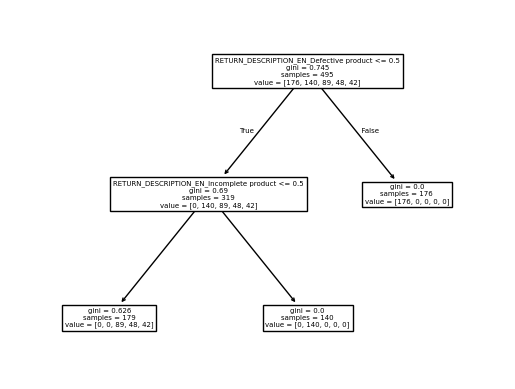

In [72]:

dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [73]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_DESCRIPTION_EN'], predicted_df], axis = 1)
model_results_frame

,RETURN_DESCRIPTION_EN,Predicted_Reason
0,Wrong product ordered,Unsatisfactory product
1,Wrong product ordered,Unsatisfactory product
2,Defective product,Defective product
3,Defective product,Defective product
4,Defective product,Defective product
...,...,...
119,Defective product,Defective product
120,Incomplete product,Incomplete product
121,Unsatisfactory product,Unsatisfactory product
122,Unsatisfactory product,Unsatisfactory product


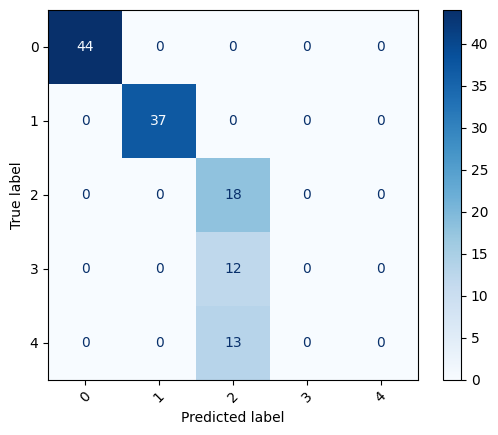

In [75]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()